In [17]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

In [2]:
# Load your data
file_path = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/suomi24.csv'
df = pd.read_csv(file_path)
df

,msg_type,datetime,title,thread_id,comment_id,topic_name_top,topic_name_leaf,thread_text,thread_text_processed,combined_processed,thread_text_hypothesis,combined_hypothesis,compound,sentiment
0,thread_start,10/21/2008 15:10,2008,6382354,0,Groups,40 plus,"but despised and questioned yes. 2008 Well, we...",but despised and questioned yes well we though...,groups plus but despised and questioned yes w...,H4,H4,0.1531,positive
1,comment,10/21/2008 16:34,2008,6382354,33460404,Groups,40 plus,Orwell was a seer. In '84 the world didn't exa...,orwell was a seer in the world did not exactly...,groups plus orwell was a seer in the world di...,H4,H4,-0.2755,negative
2,comment,3/19/2016 9:40,- I don't know. - What's the payoff?,14185813,83782764,Hobbies,Electronics,which did not protect the car owner from the r...,which did not protect the car owner from the r...,i do not know whats the payoff hobbies electro...,H3,H3,-0.8249,negative
3,comment,3/25/2016 23:48,- I don't know. - What's the payoff?,14185813,83896363,Hobbies,Electronics,"the cashier will have a ""card reported as miss...",the cashier will have a card reported as missi...,i do not know whats the payoff hobbies electro...,H2,H2,-0.8779,negative
4,comment,4/11/2016 23:06,- I don't know. - What's the payoff?,14185813,84156873,Hobbies,Electronics,but do those only Mastercard Kredit cards with...,but do those only mastercard kredit cards with...,i do not know whats the payoff hobbies electro...,H2,H2,-0.2263,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217996,comment,3/16/2013 11:54,Localities,11340784,60550054,Localities,Nickel,thank you. Who could make it happen? Camera St...,thank you who could make it happen camera stel...,localities localities nickel thank you who cou...,H2,H1,0.7964,positive
217997,comment,1/16/2015 15:03,Vehicles and transport,13305552,77069109,Vehicles and transport,Public transport,This rave junta now put the lives of possibly ...,this rave junta now put the lives of possibly ...,vehicles and transport vehicles and transport ...,H0,H4,-0.2732,negative
217998,comment,3/18/2013 13:55,Localities,11340784,60588127,Localities,Nickel,It would be nice to see what's going on there ...,it would be nice to see what is going on there...,localities localities nickel it would be nice ...,H2,H1,0.5702,positive
217999,comment,3/30/2006 8:55,Localities,2778360,14276358,Localities,Rovaniemi,did not prevent our table from stealing. Its a...,did not prevent our table from stealing its a ...,localities localities rovaniemi did not preven...,H1,H4,-0.5823,negative


In [13]:
# Dictionary for contractions
contraction_dict = {
    "it's": "it is", "aren't": "are not", "can't": "cannot", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will",
    "he's": "he is", "I'd": "I would", "I'll": "I will", "I'm": "I am", "I've": "I have",
    "isn't": "is not", "it's": "it is", "let's": "let us", "might've": "might have",
    "must've": "must have", "mustn't": "must not", "shan't": "shall not", "she'd": "she would",
    "she'll": "she will", "she's": "she is", "should've": "should have", "shouldn't": "should not",
    "that's": "that is", "there's": "there is", "they'd": "they would", "they'll": "they will",
    "they're": "they are", "they've": "they have", "we'd": "we would", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what're": "what are",
    "what's": "what is", "what've": "what have", "where's": "where is", "who'd": "who would",
    "who'll": "who will", "who's": "who is", "who've": "who have", "won't": "will not",
    "wouldn't": "would not", "you'd": "you would", "you'll": "you will", "you're": "you are",
    "you've": "you have"
}

def preprocess_text(text):
    # Regex to match:
    # 1. Any possible email address format
    # 2. URLs starting with http/https and ending with .com or .fi (with optional spaces)
    # 3. Any string that includes a slash (assumed to be a path or URL)
    # 4. Domain-like strings that end with .com or .fi, including spaces before the extensions
    patterns = [
        r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\b',  # Email addresses, more inclusive to capture 'username@hostname'
        r'https?://[^ ]*\.(com|fi)\b',             # Full URLs
        r'\b[^ ]+/[^ ]+\b',                        # Paths with slashes
        r'\b[^ ]*\.\s*(com|fi)\b'                  # Domains with optional spaces
    ]
    combined_pattern = r'|'.join(patterns)
    text = re.sub(combined_pattern, '', text)
    words = text.split()
    text = " ".join([contraction_dict.get(word, word) for word in words]) # replace contractions
    text = re.sub(r'\b\w*(-\w*)+\b', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text) # remove non-letter characters
#     text = re.sub(r'[^a-zA-Z\s!.,?]', '', text)  # Keep only letters and punctuations used by VADER
    text = re.sub(r'&[^;\s]*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()  # Convert to lower case

    return text

dff = pd.DataFrame()
tqdm.pandas(desc="Processing")

dff['title_processed'] = df['title'].progress_apply(preprocess_text)
dff['topic_name_top_processed'] = df['topic_name_top'].progress_apply(preprocess_text)
dff['topic_name_leaf_processed'] = df['topic_name_leaf'].progress_apply(preprocess_text)
dff['thread_text_processed'] = df['thread_text'].progress_apply(preprocess_text)

df['combined_processed'] = dff[['title_processed', 'topic_name_top_processed', 'topic_name_leaf_processed', 'thread_text_processed']].progress_apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
df['thread_text_processed'] =dff['thread_text_processed']
# df.to_csv('suomi24_bertweet_processed.csv', index=False)

Processing: 100%|██████████| 218001/218001 [00:22<00:00, 9867.25it/s] 


In [58]:
df

,msg_type,datetime,title,thread_id,comment_id,topic_name_top,topic_name_leaf,thread_text,thread_text_processed,combined_processed,thread_text_hypothesis,combined_hypothesis,compound,sentiment
0,thread_start,10/21/2008 15:10,2008,6382354,0,Groups,40 plus,"but despised and questioned yes. 2008 Well, we...",but despised and questioned yes well we though...,groups plus but despised and questioned yes w...,H4,H4,0.1531,positive
1,comment,10/21/2008 16:34,2008,6382354,33460404,Groups,40 plus,Orwell was a seer. In '84 the world didn't exa...,orwell was a seer in the world did not exactly...,groups plus orwell was a seer in the world di...,H4,H4,-0.2755,negative
2,comment,3/19/2016 9:40,- I don't know. - What's the payoff?,14185813,83782764,Hobbies,Electronics,which did not protect the car owner from the r...,which did not protect the car owner from the r...,i do not know whats the payoff hobbies electro...,H3,H3,-0.8249,negative
3,comment,3/25/2016 23:48,- I don't know. - What's the payoff?,14185813,83896363,Hobbies,Electronics,"the cashier will have a ""card reported as miss...",the cashier will have a card reported as missi...,i do not know whats the payoff hobbies electro...,H2,H2,-0.8779,negative
4,comment,4/11/2016 23:06,- I don't know. - What's the payoff?,14185813,84156873,Hobbies,Electronics,but do those only Mastercard Kredit cards with...,but do those only mastercard kredit cards with...,i do not know whats the payoff hobbies electro...,H2,H2,-0.2263,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217996,comment,3/16/2013 11:54,Localities,11340784,60550054,Localities,Nickel,thank you. Who could make it happen? Camera St...,thank you who could make it happen camera stel...,localities localities nickel thank you who cou...,H2,H1,0.7964,positive
217997,comment,1/16/2015 15:03,Vehicles and transport,13305552,77069109,Vehicles and transport,Public transport,This rave junta now put the lives of possibly ...,this rave junta now put the lives of possibly ...,vehicles and transport vehicles and transport ...,H0,H4,-0.2732,negative
217998,comment,3/18/2013 13:55,Localities,11340784,60588127,Localities,Nickel,It would be nice to see what's going on there ...,it would be nice to see what is going on there...,localities localities nickel it would be nice ...,H2,H1,0.5702,positive
217999,comment,3/30/2006 8:55,Localities,2778360,14276358,Localities,Rovaniemi,did not prevent our table from stealing. Its a...,did not prevent our table from stealing its a ...,localities localities rovaniemi did not preven...,H1,H4,-0.5823,negative


In [15]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores
def vader_sentiment(text):
    return analyzer.polarity_scores(text)

In [ ]:
column_for_sentiment = 'thread_text_processed'

In [44]:
df['compound'] = df['thread_text_processed'].progress_apply(vader_sentiment).progress_apply(lambda x: x['compound'])
# df['compound'] = df['vader_sentiment'].apply(lambda x: x['compound'])
df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

# df['vader_sentiment'] = df['thread_text_processed'].progress_apply(vader_sentiment)
# df['thread_text_processed_compound'] = df['vader_sentiment'].progress_apply(lambda x: x['compound']) # Extract compound scores
# df['thread_text_processed_sentiment'] = df['thread_text_processed_compound'].progress_apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

# df['vader_sentiment'] = df['combined_processed'].progress_apply(vader_sentiment)
# df['combined_processed_compound'] = df['vader_sentiment'].progress_apply(lambda x: x['compound']) # Extract compound scores
# df['combined_processed_sentiment'] = df['combined_processed_compound'].progress_apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

# df['vader_sentiment'] = df['thread_text_processed_vader'].progress_apply(vader_sentiment)
# df['thread_text_processed_vader_compound'] = df['vader_sentiment'].progress_apply(lambda x: x['compound']) # Extract compound scores
# df['thread_text_processed_vader_sentiment'] = df['thread_text_processed_vader_compound'].progress_apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

# df['vader_sentiment'] = df['combined_processed_vader'].progress_apply(vader_sentiment)
# df['combined_processed_vader_compound'] = df['vader_sentiment'].progress_apply(lambda x: x['compound']) # Extract compound scores
# df['combined_processed_vader_sentiment'] = df['combined_processed_vader_compound'].progress_apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

Processing: 100%|██████████| 218001/218001 [00:00<00:00, 1133182.22it/s]


In [45]:
print("Sentiment Counts:\n", df['sentiment'].value_counts())

# print("thread_text_processed_sentiment Counts:\n", df['thread_text_processed_sentiment'].value_counts())
# print("combined_processed_sentiment Counts:\n", df['combined_processed_sentiment'].value_counts())
# print("thread_text_processed_vader_sentiment Counts:\n", df['thread_text_processed_vader_sentiment'].value_counts())
# print("combined_processed_vader_sentiment Counts:\n", df['combined_processed_vader_sentiment'].value_counts())

Sentiment Counts:
 sentiment
positive    101666
negative     90547
neutral      25788
Name: count, dtype: int64


In [46]:
# df = df.drop(['combined_processed_vader', 'thread_text_processed_vader_sentiment', 'combined_processed_vader_sentiment'], axis=1)

In [59]:
df.to_csv('suomi24.csv', index=False)

# H0: Personal experiences with surveillance cameras significantly shape people's views on public monitoring.
# H1: Attitudes toward surveillance cameras vary significantly depending on their placement in different settings, such as shopping areas, residential blocks, and workplaces.
# H2: There are common technical complaints about surveillance cameras, and people suggest specific enhancements to address these issues.
# H3: Surveillance cameras make people feel more secure rather than feeling watched.
# H4: There is a noticeable relationship between the density of surveillance cameras in an area and public opinion regarding their presence.

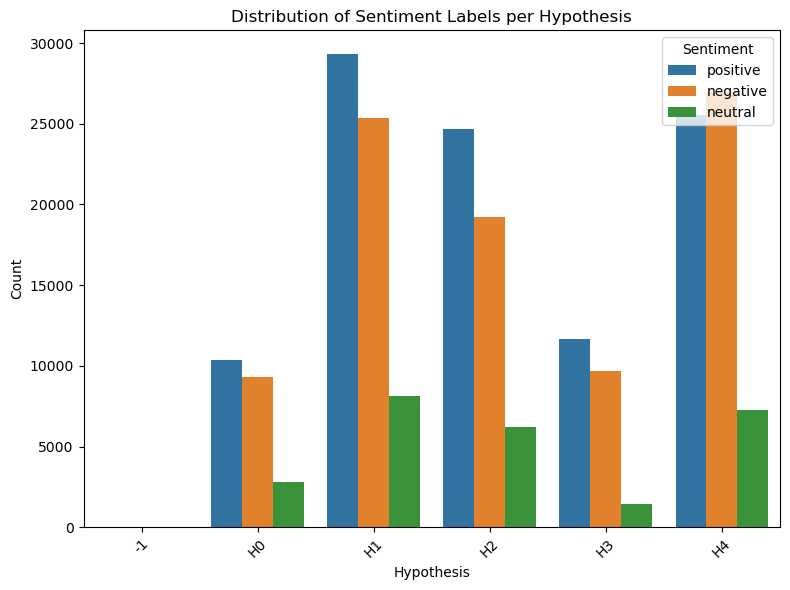

In [5]:
# Plot the distribution of sentiment labels for each hypothesis in a single graph
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='combined_hypothesis', hue='sentiment', order=sorted(df['combined_hypothesis'].unique()))
plt.title('Distribution of Sentiment Labels per Hypothesis')
plt.xlabel('Hypothesis')
plt.ylabel('Count')
plt.legend(title='Sentiment', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# # Get unique hypotheses
# hypotheses = df['combined_hypothesis'].unique()

# # Plot the distribution of sentiment labels for each hypothesis
# for hypothesis in hypotheses:
#     subset = df[df['combined_hypothesis'] == hypothesis]
#     plt.figure(figsize=(10, 6))
#     sns.countplot(data=subset, x='sentiment', order=['positive', 'neutral', 'negative'])
#     plt.title(f'Distribution of Sentiment Labels for Hypothesis {hypothesis}')
#     plt.xlabel('Sentiment')
#     plt.ylabel('Count')
#     plt.show()

In [ ]:
# Display some example rows for each sentiment
positive_examples = df[df['sentiment'] == 'positive'].sample(10)
neutral_examples = df[df['sentiment'] == 'neutral'].sample(10)
negative_examples = df[df['sentiment'] == 'negative'].sample(10)

print("Positive Examples:\n", positive_examples[['thread_text_processed']])
print("\nNeutral Examples:\n", neutral_examples[['thread_text_processed']])
print("\nNegative Examples:\n", negative_examples[['thread_text_processed']])

In [ ]:
# yearly trend of hypothesis/ evolution
# key and dominant entities occuring in sentiment types
# research the reason of starting point of heated discussions
# evolution of camera implementations/ legislation frameword/ public camera installations / accidents

C:\Users\fahad\AppData\Local\Temp\ipykernel_15640\1511096356.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year'] = pd.to_datetime(df_filtered['datetime']).dt.year


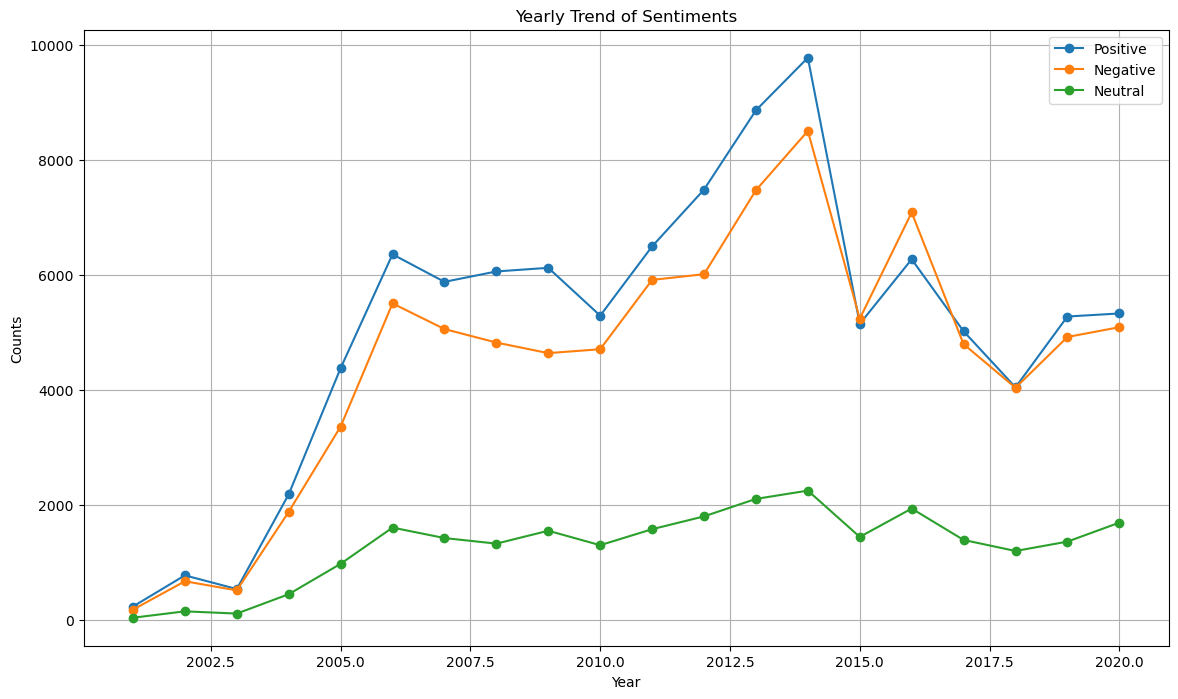

In [16]:
# Filter out rows with hypothesis '-1'
df_filtered = df[df['combined_hypothesis'] != '-1']

# Convert datetime to datetime format and extract year
df_filtered['year'] = pd.to_datetime(df_filtered['datetime']).dt.year

# Group by year and sentiment
yearly_sentiment = df_filtered.groupby(['year', 'sentiment']).size().reset_index(name='counts')

# Pivot the table
yearly_sentiment_pivot = yearly_sentiment.pivot_table(index='year', columns='sentiment', values='counts', fill_value=0)

# Plot yearly trend for all sentiments
plt.figure(figsize=(14, 8))
if 'positive' in yearly_sentiment_pivot.columns:
    plt.plot(yearly_sentiment_pivot.index, yearly_sentiment_pivot['positive'], marker='o', label='Positive')
if 'negative' in yearly_sentiment_pivot.columns:
    plt.plot(yearly_sentiment_pivot.index, yearly_sentiment_pivot['negative'], marker='o', label='Negative')
if 'neutral' in yearly_sentiment_pivot.columns:
    plt.plot(yearly_sentiment_pivot.index, yearly_sentiment_pivot['neutral'], marker='o', label='Neutral')

plt.title('Yearly Trend of Sentiments')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend(loc='best')
plt.grid(True)
plt.show()


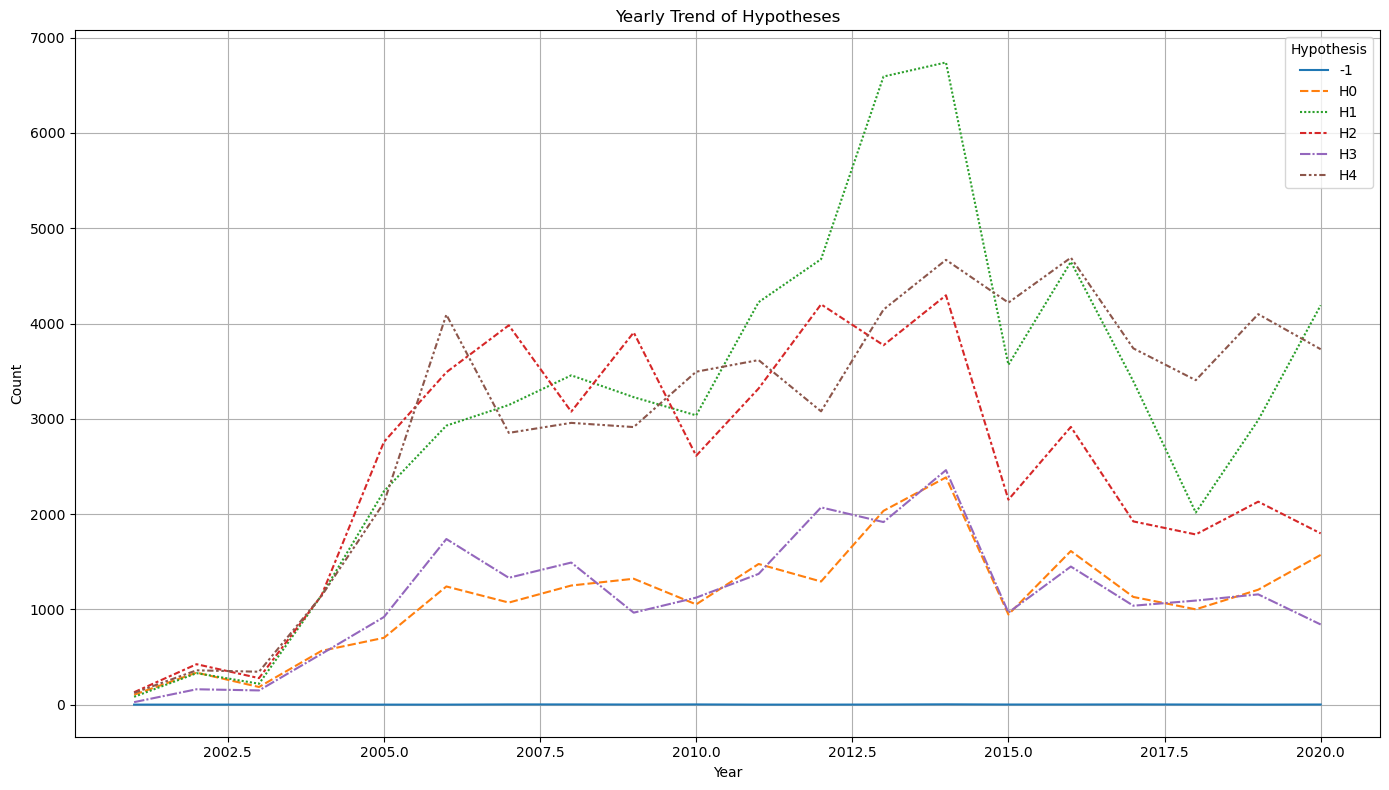

In [9]:
# Ensure 'datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract the year from the 'datetime' column
df['year'] = df['datetime'].dt.year

# Count the occurrences of each hypothesis per year
yearly_hypothesis_counts = df.groupby(['year', 'combined_hypothesis']).size().reset_index(name='counts')

# Pivot the table to get hypotheses as columns
yearly_hypothesis_pivot = yearly_hypothesis_counts.pivot(index='year', columns='combined_hypothesis', values='counts').fillna(0)

# Plot the yearly trend of each hypothesis
plt.figure(figsize=(14, 8))
sns.lineplot(data=yearly_hypothesis_pivot)
plt.title('Yearly Trend of Hypotheses')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Hypothesis', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\fahad\AppData\Local\Temp\ipykernel_15640\2599572141.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year'] = pd.to_datetime(df_filtered['datetime']).dt.year


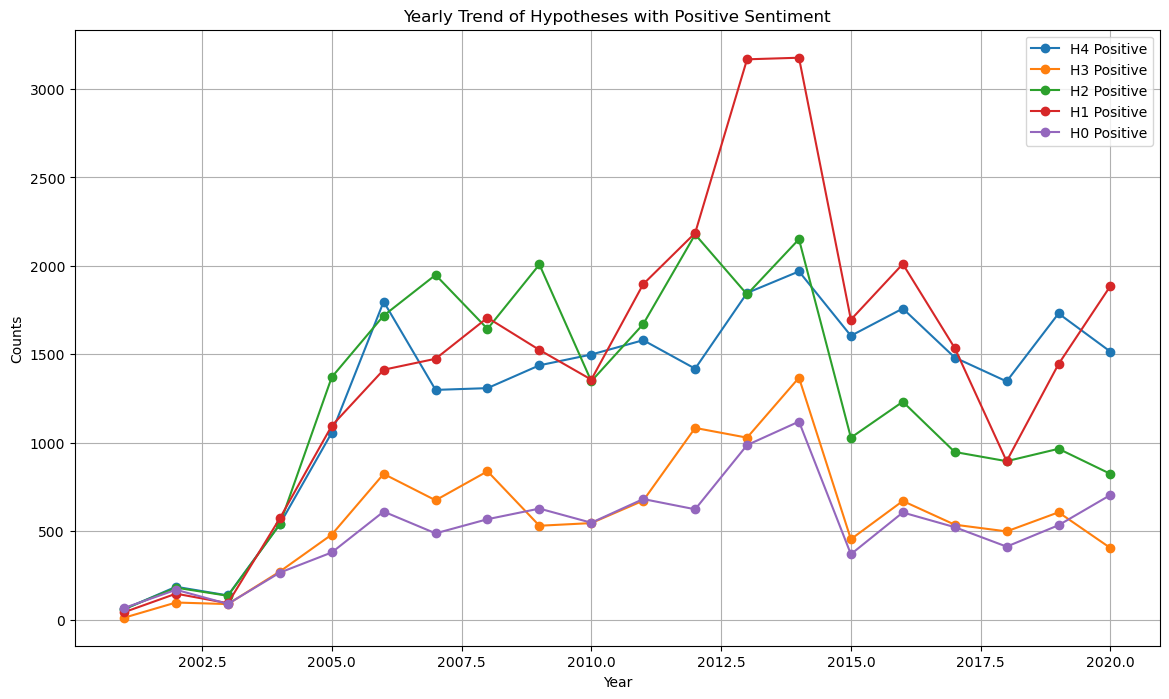

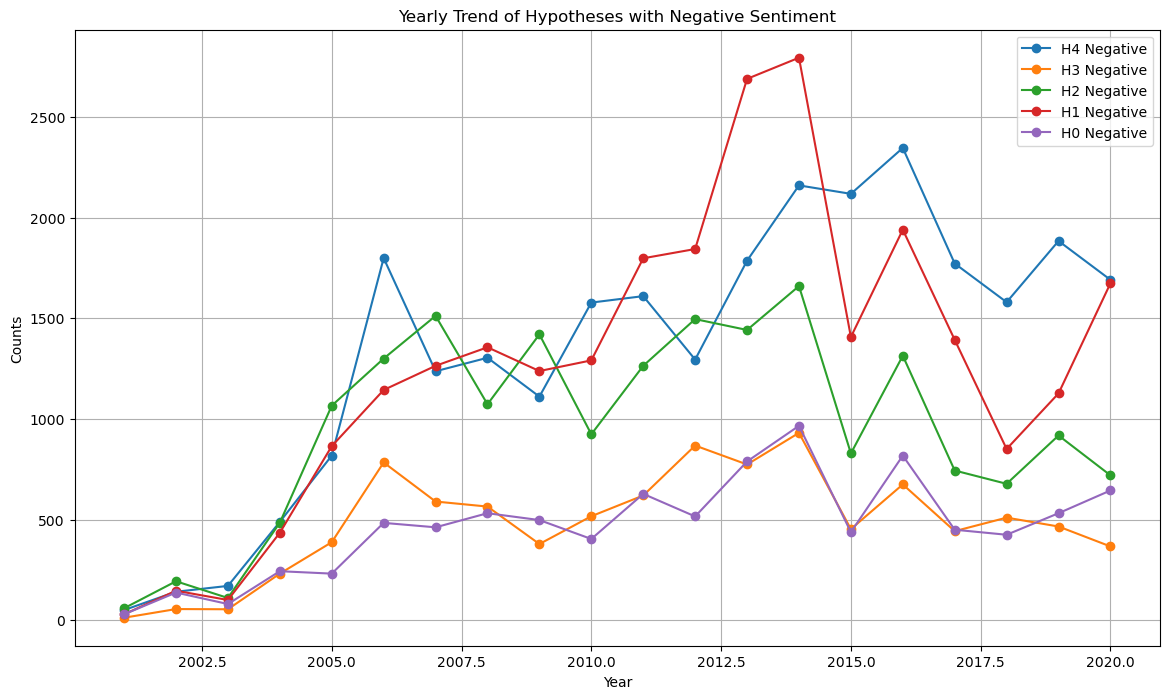

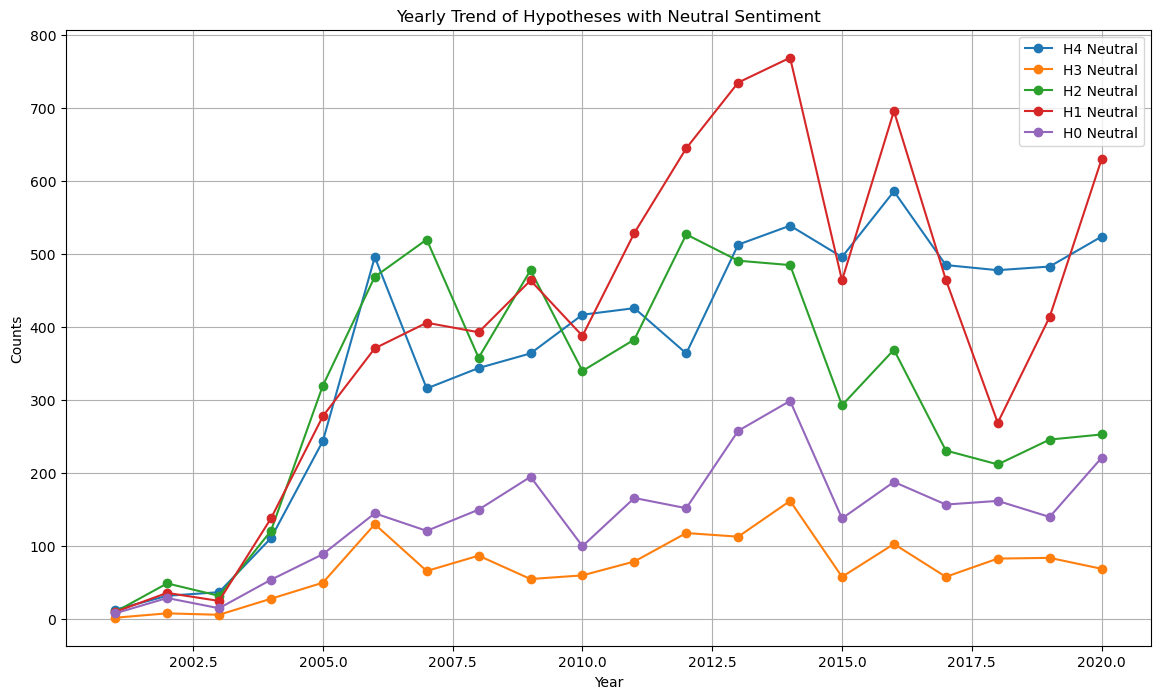

In [15]:
# Filter out rows with hypothesis '-1'
df_filtered = df[df['combined_hypothesis'] != '-1']

# Convert datetime to datetime format and extract year
df_filtered['year'] = pd.to_datetime(df_filtered['datetime']).dt.year

# Group by year, hypothesis, and sentiment
yearly_hypothesis_sentiment = df_filtered.groupby(['year', 'combined_hypothesis', 'sentiment']).size().reset_index(name='counts')

# Pivot the table
yearly_hypothesis_sentiment_pivot = yearly_hypothesis_sentiment.pivot_table(index='year', columns=['combined_hypothesis', 'sentiment'], values='counts', fill_value=0)

# Plot positive sentiment
plt.figure(figsize=(14, 8))
for hypothesis in df_filtered['combined_hypothesis'].unique():
    if 'positive' in yearly_hypothesis_sentiment_pivot[hypothesis].columns:
        plt.plot(yearly_hypothesis_sentiment_pivot.index, yearly_hypothesis_sentiment_pivot[hypothesis]['positive'], marker='o', label=f'{hypothesis} Positive')

plt.title('Yearly Trend of Hypotheses with Positive Sentiment')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plot negative sentiment
plt.figure(figsize=(14, 8))
for hypothesis in df_filtered['combined_hypothesis'].unique():
    if 'negative' in yearly_hypothesis_sentiment_pivot[hypothesis].columns:
        plt.plot(yearly_hypothesis_sentiment_pivot.index, yearly_hypothesis_sentiment_pivot[hypothesis]['negative'], marker='o', label=f'{hypothesis} Negative')

plt.title('Yearly Trend of Hypotheses with Negative Sentiment')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plot neutral sentiment
plt.figure(figsize=(14, 8))
for hypothesis in df_filtered['combined_hypothesis'].unique():
    if 'neutral' in yearly_hypothesis_sentiment_pivot[hypothesis].columns:
        plt.plot(yearly_hypothesis_sentiment_pivot.index, yearly_hypothesis_sentiment_pivot[hypothesis]['neutral'], marker='o', label=f'{hypothesis} Neutral')

plt.title('Yearly Trend of Hypotheses with Neutral Sentiment')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend(loc='best')
plt.grid(True)
plt.show()


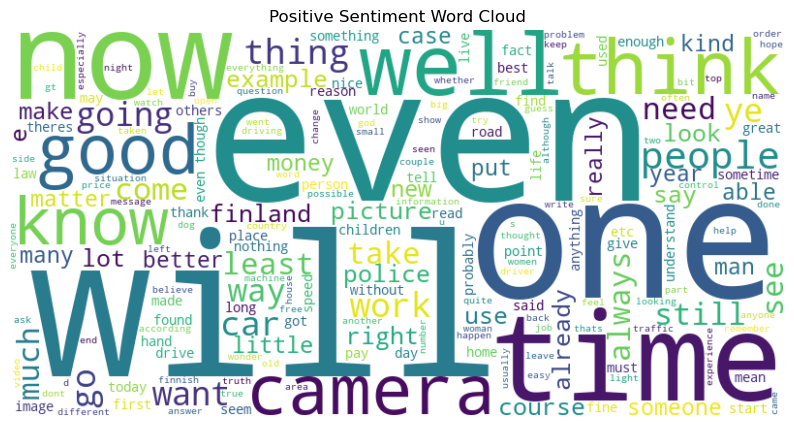

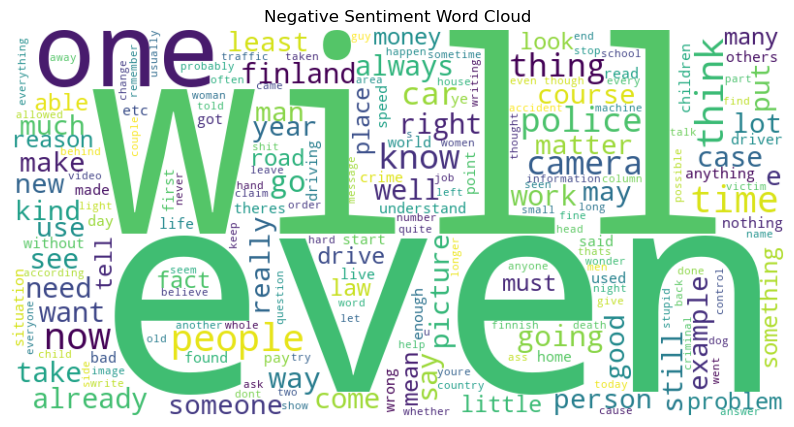

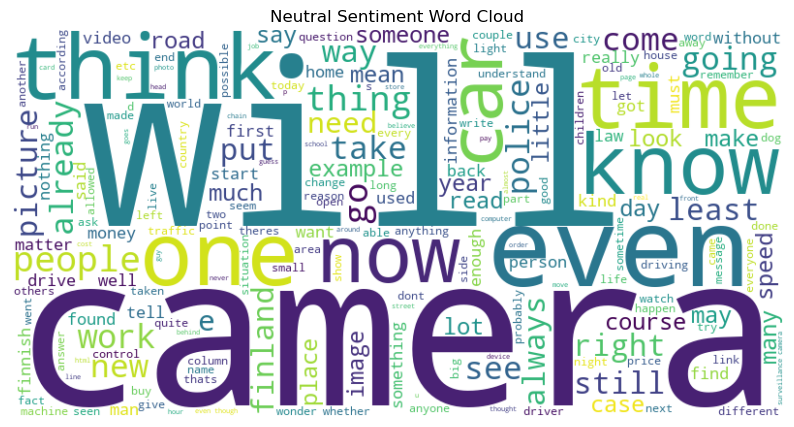

In [19]:
# Generate word clouds for each sentiment type
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Filter the texts by sentiment
positive_text = df[df['sentiment'] == 'positive']['thread_text_processed']
negative_text = df[df['sentiment'] == 'negative']['thread_text_processed']
neutral_text = df[df['sentiment'] == 'neutral']['thread_text_processed']

# Generate word clouds
generate_word_cloud(positive_text, 'Positive Sentiment Word Cloud')
generate_word_cloud(negative_text, 'Negative Sentiment Word Cloud')
generate_word_cloud(neutral_text, 'Neutral Sentiment Word Cloud')


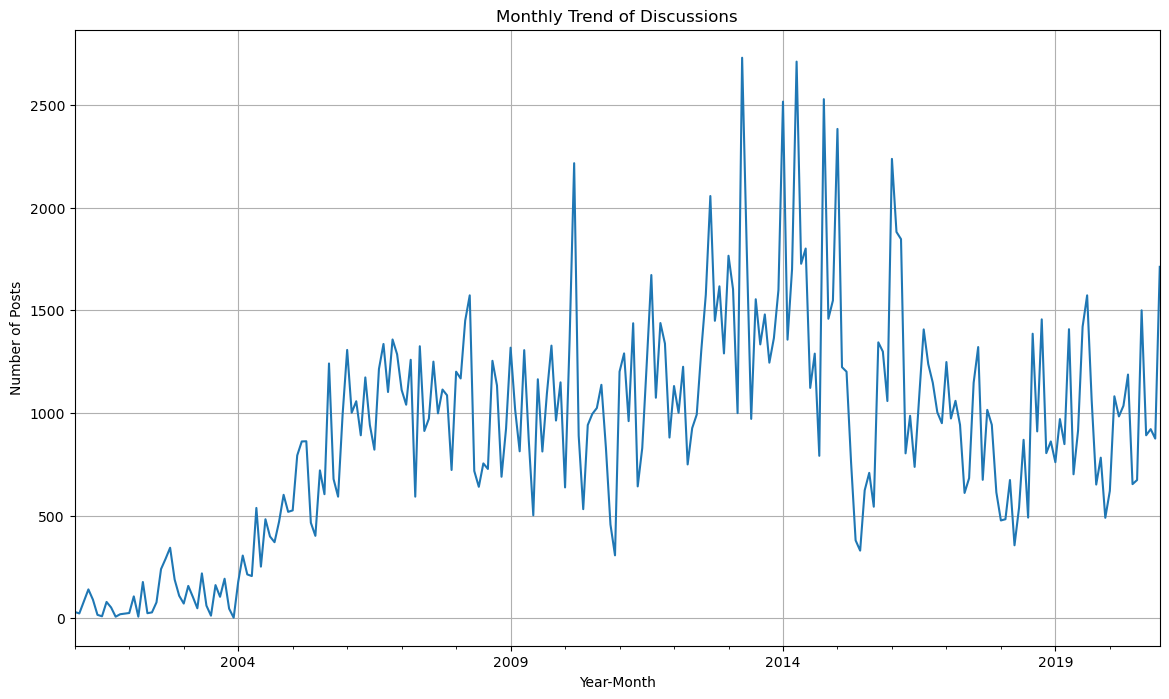

Top 10 months with highest increase in posts:
year_month
2014-10    1738.0
2013-04    1732.0
2016-01    1180.0
2014-04    1011.0
2014-01     918.0
2018-08     896.0
2011-01     895.0
2010-03     860.0
2020-12     837.0
2015-01     836.0
Freq: M, Name: count, dtype: float64


In [20]:
# Group by year and month to see trends over time
df['year_month'] = pd.to_datetime(df['datetime']).dt.to_period('M')
monthly_counts = df['year_month'].value_counts().sort_index()

plt.figure(figsize=(14, 8))
monthly_counts.plot()
plt.title('Monthly Trend of Discussions')
plt.xlabel('Year-Month')
plt.ylabel('Number of Posts')
plt.grid(True)
plt.show()

# Find months with the highest increase in posts
monthly_counts_diff = monthly_counts.diff().dropna()
top_increases = monthly_counts_diff.nlargest(10)

print("Top 10 months with highest increase in posts:")
print(top_increases)
